#RL Mountain Car

Get and import necessary dep LIB

In [1]:
%rm -rf *
!git clone https://github.com/amirjarareh/RL
%mv /content/RL/* /content/
%rm -rf RL
!pip install -r requirment.txt

Cloning into 'RL'...
remote: Enumerating objects: 11, done.
remote: Counting objects: 100% (11/11), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 11 (delta 2), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (11/11), 6.22 KiB | 3.11 MiB/s, done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.8/21.8 MB 36.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 51.6 MB/s eta 0:00:00
  Created wheel for gym.wrappers: filename=gym_wrappers-0.1.0-py3-none-any.whl size=1412 sha256=69af7a91f1b29df1dc80c2cad6f76ebef90079442958cf20ca922e07349fafcd
  Stored in directory: /root/.cache/pip/wheels/bf/e5/1a/7a9feba5120117a78b2fe42ef373e998ae2dcc068514794768
Successfully built gym.wrappers


In [2]:
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pickle as pk
%matplotlib inline

In [4]:
import glob, io, base64
from IPython.display import HTML
from pyvirtualdisplay import Display
from IPython import display as ipythondisplay

In [5]:
from mpl_toolkits.mplot3d import Axes3D  
import tiles3 as tc
from tqdm import tqdm 
import utils
import gym
from gym.wrappers import RecordEpisodeStatistics
from gym.wrappers import RecordVideo
import warnings

Video Functions

In [6]:
def display_video():
    videos = glob.glob('video/*.mp4')
    if len(videos) > 0:
        ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(base64.b64encode(io.open(videos[0], 'r+b').read()).decode('ascii'))))

create env

Tile Codding Functions

In [7]:
class MCTC:
    def __init__(self,iht_size, num_tilings, num_tiles):
        self.iht = tc.IHT(iht_size)
        self.num_tilings = num_tilings
        self.num_tiles = num_tiles
    
    def get_tiles(self, pos, vel):
        p_size = self.num_tiles / (0.6 + 1.2)
        v_size = self.num_tiles / (0.07+0.07)
        tiles = tc.tiles(self.iht, self.num_tilings, [pos * p_size, vel * v_size])
        return np.array(tiles)

Sarsa

In [8]:
def run_action(Q, tiles, eps, na):
    actions = []
    out = None
    actions = np.sum(Q[:, tiles], axis = 1)
    
    if np.random.random() < eps:
        out = np.random.randint(na)
    else:
        out = np.argmax(actions)
    return out

Train
tilings = 8 tiles = 8 iht_size = 4096

In [10]:
steps_sum = []
rewards_sun = []

steps = []
rewards = []
env = gym.make('MountainCar-v0')
num_runs = 1
num_episodes = 500
env.reset()
env._max_episode_steps = 1000

num_tilings =  8
num_tiles = 8
iht_size =  4096

eps = 0.0
alpha =  0.5 / num_tilings
na = 3
Q = np.ones((na, iht_size)) * 0
mctc = MCTC(iht_size,num_tilings,num_tiles)
for i in range(num_runs):
    obs = env.reset()
    steps_per_episode = []
    rewards_per_episode = []
    pos, vel = obs
    at = mctc.get_tiles(pos, vel)
    ca = run_action(Q, at, eps, na)
    la = ca
    pt = np.copy(at)

    for t in tqdm(range(num_episodes)):
        n = 0
        R = 0
        done = False
        obs = env.reset()
        while not done:
            obs, r, done, info = env.step(la)
            n +=1
            R = R + r
            if not done:
              # agent step
              pos, vel = obs
              at = mctc.get_tiles(pos, vel)
              ca = run_action(Q, at, eps, na)
              Q[la][pt] = Q[la][pt] + alpha*(r* Q[ca][at] - Q[la][pt])
              la = ca
              pt = np.copy(at)
            else:
              Q[la][pt] = Q[la][pt] + alpha*(r - Q[la][pt])
        steps_per_episode.append(n)
        rewards_per_episode.append(R)
    
    steps.append(np.array(steps_per_episode))
    rewards.append(np.array(rewards_per_episode))

steps_sum.append(steps)
rewards_sun.append(rewards)
env.close()


100%|██████████| 500/500 [00:52<00:00,  9.54it/s]


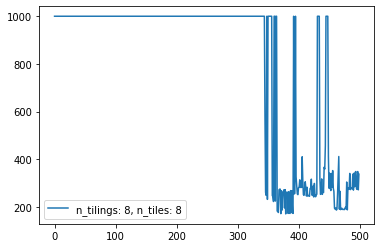

In [11]:
plt.plot(np.mean(np.array(steps), axis=0), label = 'n_tilings: 8, n_tiles: 8')
plt.legend()
plt.show()

Test

In [12]:
num_t = 1000

env_test = gym.make('MountainCar-v0')
env_test._max_episode_steps = 1000
env = RecordVideo(env_test, './video' )
obs = env.reset()
pos, vel = obs
at = mctc.get_tiles(pos, vel)
la = run_action(Q, at, 0, 3)
pt = np.copy(at)
for t in range(num_t):
    env.render()
    obs ,_ ,done ,_= env.step(la)
    if not done:
        pos, vel = obs
        at = mctc.get_tiles(pos, vel)
        la = run_action(Q, at, 0, 3)
        pt = np.copy(at)
    else:
        break
env.close()
env_test.close()
display_video()

/usr/local/lib/python3.8/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.8/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.8/dist-packages/gym/wrappers/monitoring/video_recorder.py:78: DeprecationWarning: WARN: Recording ability for environment MountainCar-v0 initialized with `render_mode=None` is marked as deprecated and will be removed in the future.
  logger.deprecation(
/usr/local/lib/python3.8/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is depr

Train
tilings = 2 tiles = 16 iht_size = 4096

In [13]:
steps_sum = []
rewards_sun = []

steps = []
rewards = []
env = gym.make('MountainCar-v0')
num_runs = 1
num_episodes = 500
env.reset()
env._max_episode_steps = 1000

num_tilings =  2
num_tiles = 16
iht_size =  4096

eps = 0.0
alpha =  0.5 / num_tilings
na = 3
Q = np.ones((na, iht_size)) * 0
mctc = MCTC(iht_size,num_tilings,num_tiles)
for i in range(num_runs):
    obs = env.reset()
    steps_per_episode = []
    rewards_per_episode = []
    pos, vel = obs
    at = mctc.get_tiles(pos, vel)
    ca = run_action(Q, at, eps, na)
    la = ca
    pt = np.copy(at)

    for t in tqdm(range(num_episodes)):
        n = 0
        R = 0
        done = False
        obs = env.reset()
        while not done:
            obs, r, done, info = env.step(la)
            n +=1
            R = R + r
            if not done:
              # agent step
              pos, vel = obs
              at = mctc.get_tiles(pos, vel)
              ca = run_action(Q, at, eps, na)
              Q[la][pt] = Q[la][pt] + alpha*(r* Q[ca][at] - Q[la][pt])
              la = ca
              pt = np.copy(at)
            else:
              Q[la][pt] = Q[la][pt] + alpha*(r - Q[la][pt])
        steps_per_episode.append(n)
        rewards_per_episode.append(R)
    
    steps.append(np.array(steps_per_episode))
    rewards.append(np.array(rewards_per_episode))

steps_sum.append(steps)
rewards_sun.append(rewards)
env.close()


/usr/local/lib/python3.8/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.8/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
100%|██████████| 500/500 [00:55<00:00,  9.01it/s]


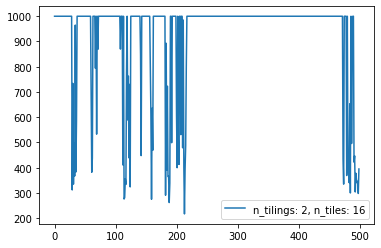

In [14]:
plt.plot(np.mean(np.array(steps), axis=0), label = 'n_tilings: 2, n_tiles: 16')
plt.legend()
plt.show()

Test

In [15]:
%rm -rf video/

In [16]:
num_t = 1000

env_test = gym.make('MountainCar-v0')
env_test._max_episode_steps = 1000
env = RecordVideo(env_test, './video' )
obs = env.reset()
pos, vel = obs
at = mctc.get_tiles(pos, vel)
la = run_action(Q, at, 0, 3)
pt = np.copy(at)
for t in range(num_t):
    env.render()
    obs ,_ ,done ,_= env.step(la)
    if not done:
        pos, vel = obs
        at = mctc.get_tiles(pos, vel)
        la = run_action(Q, at, 0, 3)
        pt = np.copy(at)
    else:
        break
env.close()
env_test.close()
display_video()

/usr/local/lib/python3.8/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.8/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.8/dist-packages/gym/wrappers/monitoring/video_recorder.py:78: DeprecationWarning: WARN: Recording ability for environment MountainCar-v0 initialized with `render_mode=None` is marked as deprecated and will be removed in the future.
  logger.deprecation(
/usr/local/lib/python3.8/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is depr

Train
tilings = 32 tiles = 4 iht_size = 4096

In [17]:
steps_sum = []
rewards_sun = []

steps = []
rewards = []
env = gym.make('MountainCar-v0')
num_runs = 1
num_episodes = 500
env.reset()
env._max_episode_steps = 1000

num_tilings =  32
num_tiles = 4
iht_size =  4096

eps = 0.0
alpha =  0.5 / num_tilings
na = 3
Q = np.ones((na, iht_size)) * 0
mctc = MCTC(iht_size,num_tilings,num_tiles)
for i in range(num_runs):
    obs = env.reset()
    steps_per_episode = []
    rewards_per_episode = []
    pos, vel = obs
    at = mctc.get_tiles(pos, vel)
    ca = run_action(Q, at, eps, na)
    la = ca
    pt = np.copy(at)

    for t in tqdm(range(num_episodes)):
        n = 0
        R = 0
        done = False
        obs = env.reset()
        while not done:
            obs, r, done, info = env.step(la)
            n +=1
            R = R + r
            if not done:
              # agent step
              pos, vel = obs
              at = mctc.get_tiles(pos, vel)
              ca = run_action(Q, at, eps, na)
              Q[la][pt] = Q[la][pt] + alpha*(r* Q[ca][at] - Q[la][pt])
              la = ca
              pt = np.copy(at)
            else:
              Q[la][pt] = Q[la][pt] + alpha*(r - Q[la][pt])
        steps_per_episode.append(n)
        rewards_per_episode.append(R)
    
    steps.append(np.array(steps_per_episode))
    rewards.append(np.array(rewards_per_episode))

steps_sum.append(steps)
rewards_sun.append(rewards)
env.close()


/usr/local/lib/python3.8/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.8/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
100%|██████████| 500/500 [00:42<00:00, 11.78it/s]


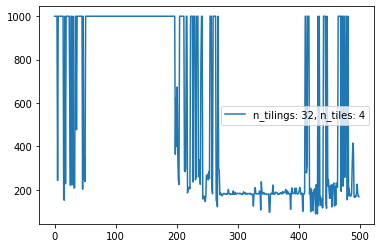

In [18]:
plt.plot(np.mean(np.array(steps), axis=0), label = 'n_tilings: 32, n_tiles: 4')
plt.legend()
plt.show()

Test

In [19]:
%rm -rf video/

In [20]:
num_t = 1000

env_test = gym.make('MountainCar-v0')
env_test._max_episode_steps = 1000
env = RecordVideo(env_test, './video' )
obs = env.reset()
pos, vel = obs
at = mctc.get_tiles(pos, vel)
la = run_action(Q, at, 0, 3)
pt = np.copy(at)
for t in range(num_t):
    env.render()
    obs ,_ ,done ,_= env.step(la)
    if not done:
        pos, vel = obs
        at = mctc.get_tiles(pos, vel)
        la = run_action(Q, at, 0, 3)
        pt = np.copy(at)
    else:
        break
env.close()
env_test.close()
display_video()

/usr/local/lib/python3.8/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.8/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.8/dist-packages/gym/wrappers/monitoring/video_recorder.py:78: DeprecationWarning: WARN: Recording ability for environment MountainCar-v0 initialized with `render_mode=None` is marked as deprecated and will be removed in the future.
  logger.deprecation(
/usr/local/lib/python3.8/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is depr

#Deep Q-Network (DQN) on LunarLander-v2


Import the Necessary Packages

In [21]:
!pip install gym[box2d] 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 KB 8.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 56.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 92.5 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for box2d-py
  Running setup.py clean for box2d-py
Failed to build box2d-py
  Running setup.py install for box2d-py ... done
  DEPRECATION: box2d-py was installed using the legacy 'setup.py install' method, because a wheel could not be built for it. A possible replacement is to fix the wheel build issue reported above. Discussion can be found at https:

In [22]:
import gym
import random

from gym.wrappers.monitoring import video_recorder
from IPython.display import HTML
from IPython import display 

In [23]:
import matplotlib.pyplot as plt
import base64, io, glob
import numpy as np
from collections import deque, namedtuple

In [24]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

Initialize the environment.



In [25]:
env = gym.make('LunarLander-v2')

/usr/local/lib/python3.8/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.8/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


Define Neural Network Architecture.

In [36]:
class DeepQNetwork(nn.Module):

    def __init__(self, state_size, action_size):
        super(DeepQNetwork, self).__init__()
        self.seed = torch.manual_seed(0)
        self.linear_1 = nn.Linear(state_size, 64)
        self.linear_2 = nn.Linear(64, 64)
        self.linear_3 = nn.Linear(64, action_size)
        
    def forward(self, state):
        x = self.linear_1(state)
        x = F.relu(x)
        x = self.linear_2(x)
        x = F.relu(x)
        return self.linear_3(x)

Define some hyperparameter

In [37]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [38]:
GAMMA = 0.98 
TAU = 1e-2     
BUFFER_SIZE = int(1e3) 
BATCH_SIZE = 64          
LR = 5e-4     
UPDATE_EVERY = 2

Define Agent

In [39]:
class HandleMem:
    def __init__(self, action_size, buffer_size = 1000, batch_size = 64):
        self.action_size = action_size
        self.mem = deque(maxlen=buffer_size)  
        self.batch_size = batch_size
        self.exp = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        # self.seed = random.seed(0)
    
    def set(self, state, action, reward, next_state, done):
        e = self.exp(state, action, reward, next_state, done)
        self.mem.append(e)
    
    def instace_period(self):
        exp = random.sample(self.mem, k=self.batch_size)
        states = torch.from_numpy(np.vstack([e.state for e in exp if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in exp if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in exp if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in exp if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in exp if e is not None]).astype(np.uint8)).float().to(device)
        return (states, actions, rewards, next_states, dones)
    def get_len(self):
        return len(self.mem)


In [40]:
class Agent():

    def __init__(self, state_size, action_size):
        self.s_size = state_size
        self.a_size = action_size
        self.seed = random.seed(0)

        # DeepQ-Network
        self.local_model = DeepQNetwork(self.s_size, self.a_size).to(device)
        self.target_model = DeepQNetwork(self.s_size, self.a_size).to(device)
        self.optimizer = optim.Adam(self.local_model.parameters(), lr=1e-3)
        self.mem = HandleMem(action_size, 1000, 64)
        self.t_s = 0
    
    def step(self, state, action, reward, next_state, done):
        self.mem.set(state, action, reward, next_state, done)
        self.t_s = (self.t_s + 1) % 2
        if self.t_s == 0:
            # If enough samples are available in memory, get random subset and learn
            if self.mem.get_len() > 64:
                self.learn(self.mem.instace_period(), 0.98)

    def act(self, state, eps=0):
        eps = 0
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.local_model.eval()
        with torch.no_grad():
            action_values = self.local_model(state)
        self.local_model.train()
        if random.random() > eps:
            out = np.argmax(action_values.cpu().data.numpy())
            return out
        else:
            out = random.choice(np.arange(self.action_size))
            return out

    def learn(self, experiences, gamma):
        states, actions, rewards, next_states, dones = experiences
        q_targets_next = self.target_model(next_states).detach().max(1)[0].unsqueeze(1)
        q_targets = rewards + gamma * q_targets_next * (1 - dones)
        q_expected = self.local_model(states).gather(1, actions)
        loss = F.mse_loss(q_expected, q_targets)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        local_model = self.local_model
        target_model = self.target_model
        tau = 0.01
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)


Training Process

In [54]:
def dqn(n_episodes=1000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    scores = []                        
    scores_window = deque(maxlen=100) 
    eps = eps_start
    for i_episode in range(1, n_episodes+1):
        state = env.reset()
        score = 0
        for t in range(max_t):
            action = agent.act(state, eps)
            next_state, reward, done, _ = env.step(action)
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break 
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        print('\repisode {} ({})'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\repisode {} ({})'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>=200.0:
            print('\repisode {} ({})'.format(i_episode-100, np.mean(scores_window)))
            torch.save(agent.local_model.state_dict(), './model_weight.pth')
            break
    return scores,agent

agent = Agent(state_size=8, action_size=4)
scores,agent = dqn()
torch.save(agent.local_model.state_dict(), './model_weight.pth')

episode 100 (-178.9544351460746)
episode 200 (-66.92816634140085)
episode 300 (-51.48841137476247)
episode 400 (-1.1229582631786257)
episode 500 (-25.68749152069899)
episode 600 (-75.39473543268448)
episode 700 (-119.04236099445767)
episode 800 (-9.888357063610279)
episode 900 (68.91195823051638)
episode 1000 (0.4327918054481759)


video displaying

In [57]:
def display_video_model(agent, env_name):
    env = gym.make(env_name)
    vid = video_recorder.VideoRecorder(env, path="{}.mp4".format(env_name))
    agent.local_model.load_state_dict(torch.load('./model_weight.pth'))
    state = env.reset()
    done = False
    while not done:
        frame = env.render(mode='rgb_array')
        vid.capture_frame()
        action = agent.act(state)
        state, _, done, _ = env.step(action)        
    env.close()

In [56]:
def display_video():
    videos = glob.glob('video/*.mp4')
    if len(videos) > 0:
        ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(base64.b64encode(io.open(videos[0], 'r+b').read()).decode('ascii'))))

In [67]:
agent = Agent(state_size=8, action_size=4)
display_video_model(agent, 'LunarLander-v2')

/usr/local/lib/python3.8/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.8/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.8/dist-packages/gym/wrappers/monitoring/video_recorder.py:78: DeprecationWarning: WARN: Recording ability for environment LunarLander-v2 initialized with `render_mode=None` is marked as deprecated and will be removed in the future.
  logger.deprecation(
/usr/local/lib/python3.8/dist-packages/gym/wrappers/monitoring/video_recorder.py:101: DeprecationWarning: WARN: <class 'gym

In [70]:
display_video()

Plot the learning progress

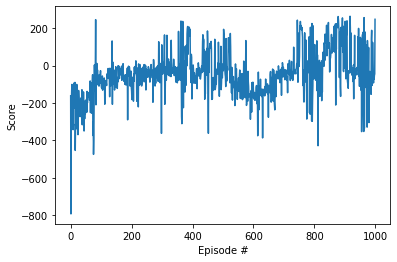

In [55]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()